In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| include: false
import numpy as np
import torch
import torch.nn as nn
from fasterai.sparse.all import *
from fastai.vision.all import *

In [ ]:
#| include: false
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

A sparse vector, as opposed to a dense one, is a vector which contains a lot of zeroes. When we speak about making a neural network sparse, we thus mean that the network's weight are mostly zeroes.

With fasterai, you can do that thanks to the `Sparsifier` class.

Let's start by creating a model

In [ ]:
model = resnet18()

As you probably know, weights in a convolutional neural network have 4 dimensions ($ c_{out} \times c_{in} \times k_h \times k_w$)

In [ ]:
model.conv1.weight.ndim

4

In [ ]:
#| include: false
def plot_kernels(layer, save=None):
    kernels = abs(layer.weight.detach().clone())
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    img = make_grid(kernels, nrow=8, padding=1, pad_value=0.137)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

In the case of ResNet18, the dimension of the first layer weights is $64 \times 3 \times 7 \times 7$. We thus can plot each of the $64$ filter as a $7 \times 7$ color image (because they contains $3$ channels).

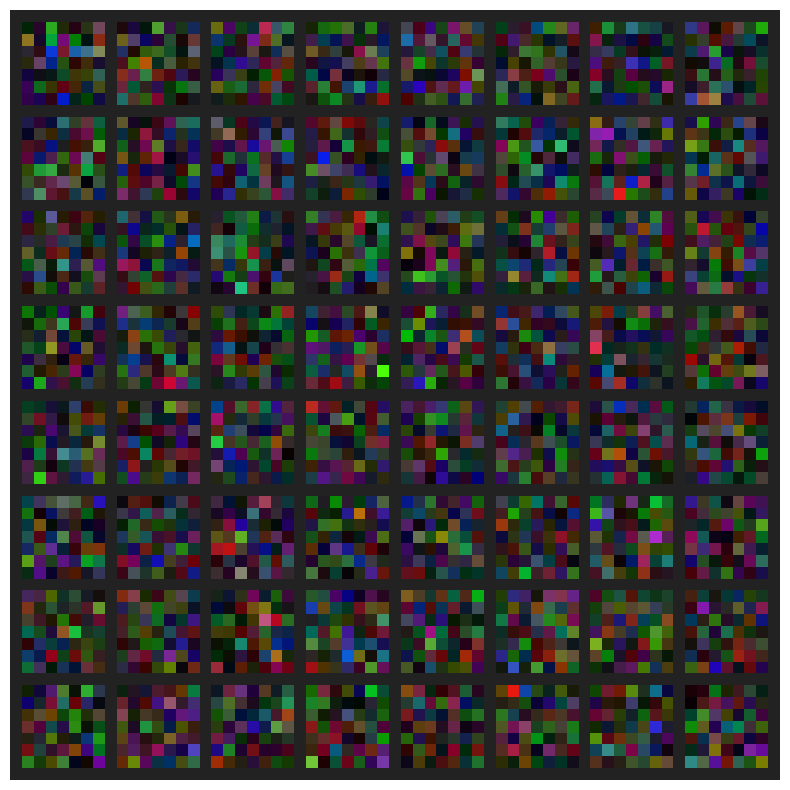

In [ ]:
plot_kernels(model.conv1)

The `Sparsifier` class allows us to remove some (part of) the filters, that are considered to be less useful than others. This can be done by first creating an instance of the class, specifying:

- The `granularity`, i.e. the part of filters that you want to remove. Typically, we usually remove weights, vectors, kernels or even complete filters.
- The `context`, i.e. if you want to consider each layer independently (`local`), or compare the parameters to remove across the whole network (`global`).
- The `criteria`, i.e. the way to assess the usefulness of a parameter. Common methods compare parameters using their magnitude, the lowest magnitude ones considered to be less useful.

User can pass a single layer to prune by using the  `Sparsifier.sparsify_layer` method.

In [ ]:
show_doc(Sparsifier.sparsify_layer)

Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/sparse/sparsifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Sparsifier.sparsify_layer

```python

def sparsify_layer(
    m:nn.Module, # The layer to sparsify
    sparsity:float, # Target sparsity level (percentage)
    round_to:Optional[int]=None, # Round to a multiple of this value
)->None:


```

*Apply sparsification to a single layer*

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'local', large_final)
sparsifier.sparsify_layer(model.conv1, 70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      6,615         70.31%
Layer 1              Conv2d          36,864     0              0.00%
Layer 2              Conv2d          36,864     0              0.00%
Layer 3              Conv2d          36,864     0              0.00%
Layer 4              Conv2d          36,864     0              0.00%
Layer 5              Conv2d          73,728     0              0.00%
Layer 6              Conv2d          147,456    0              0.00%
Layer 7              Conv2d          8,192      0              0.00%
Layer 8              Conv2d          147,456    0              0.00%
Layer 9              Conv2d          147,456    0              0.00%
Layer 10             Conv2d          294,912    0           

Most of the time, we may want to prune the whole model at once, using the `Sparsifier.sparsify_model` method, indicating the percentage of sparsity to you want to apply.

In [ ]:
show_doc(Sparsifier.sparsify_model)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/sparse/sparsifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Sparsifier.sparsify_model

```python

def sparsify_model(
    sparsity:Union[float, list[float]], # Target sparsity level(s)
    round_to:Optional[int]=None, # Round to a multiple of this value
)->None:


```

*Apply sparsification to all matching layers in the model*

There are several ways in which we can make that first layer sparse. You will find the most important below:

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'local', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      6,585         69.99%
Layer 1              Conv2d          36,864     25,805        70.00%
Layer 2              Conv2d          36,864     25,805        70.00%
Layer 3              Conv2d          36,864     25,805        70.00%
Layer 4              Conv2d          36,864     25,805        70.00%
Layer 5              Conv2d          73,728     51,609        70.00%
Layer 6              Conv2d          147,456    103,219       70.00%
Layer 7              Conv2d          8,192      5,734         70.00%
Layer 8              Conv2d          147,456    103,219       70.00%
Layer 9              Conv2d          147,456    103,219       70.00%
Layer 10             Conv2d          294,912    206,438     

You now have a model that is $70\%$ sparse ! 

## Granularity

As we said earlier, the `granularity` defines the structure of parameter that you will remove.

In the example below, we removed `weight` from each convolutional filter, meaning that we now have sparse filters, as can be seen in the image below:

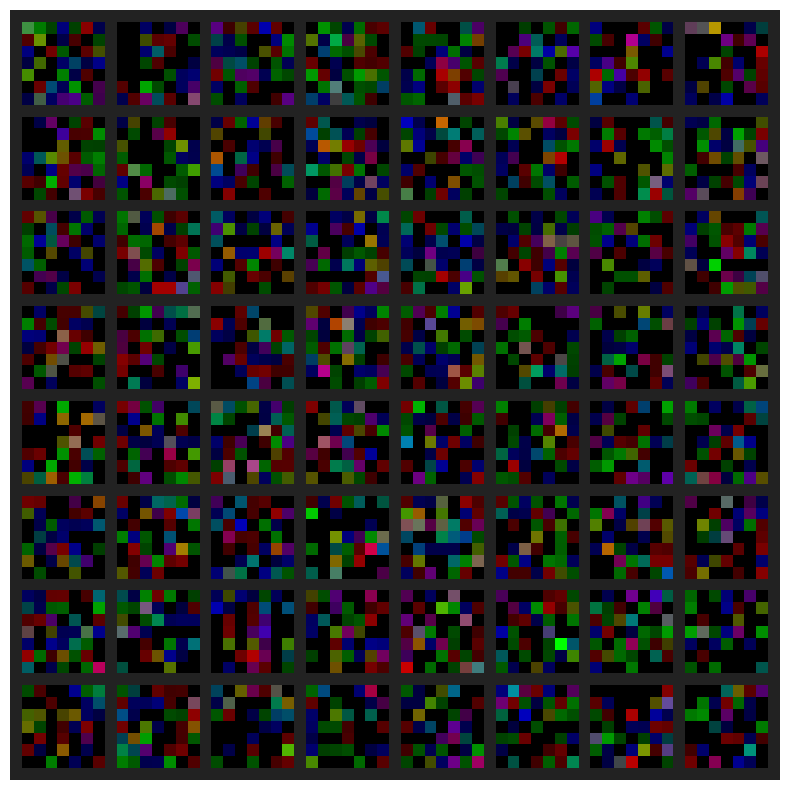

In [ ]:
plot_kernels(model.conv1)

Another granularity is, for example, removing `column` vectors from the filters. To do so, just change the granularity parameter accordingly.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'column', 'local', large_final)
sparsifier.sparsify_layer(model.conv1, 70)

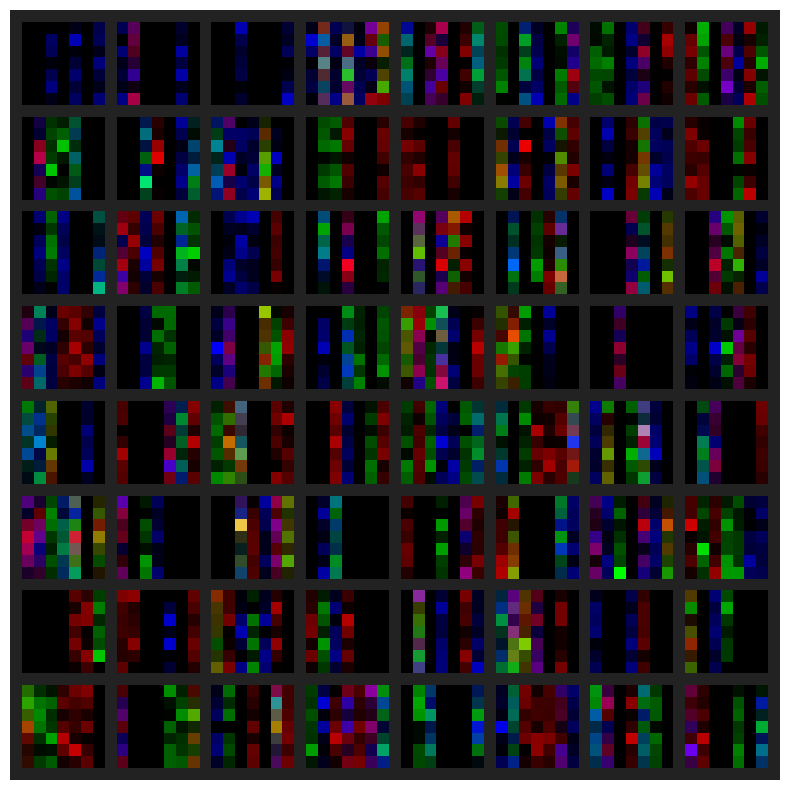

In [ ]:
plot_kernels(model.conv1)

For more information and examples about the pruning granularities, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/granularity.html).

## Context

The context defines where to look in the model, i.e. from where do we compare weight. The two basic contexts are:
* local, i.e. we compare weight from each layer individually. This will lead to layers with similar levels of sparsity.
* global, i.e. we compare weight from the whole model. This will lead to layers with different levels of sparsity

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'local', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      6,585         69.99%
Layer 1              Conv2d          36,864     25,805        70.00%
Layer 2              Conv2d          36,864     25,805        70.00%
Layer 3              Conv2d          36,864     25,805        70.00%
Layer 4              Conv2d          36,864     25,805        70.00%
Layer 5              Conv2d          73,728     51,609        70.00%
Layer 6              Conv2d          147,456    103,219       70.00%
Layer 7              Conv2d          8,192      5,734         70.00%
Layer 8              Conv2d          147,456    103,219       70.00%
Layer 9              Conv2d          147,456    103,219       70.00%
Layer 10             Conv2d          294,912    206,438     

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      6,239         66.32%
Layer 1              Conv2d          36,864     11,890        32.25%
Layer 2              Conv2d          36,864     11,923        32.34%
Layer 3              Conv2d          36,864     11,748        31.87%
Layer 4              Conv2d          36,864     11,827        32.08%
Layer 5              Conv2d          73,728     32,599        44.22%
Layer 6              Conv2d          147,456    65,040        44.11%
Layer 7              Conv2d          8,192      1,217         14.86%
Layer 8              Conv2d          147,456    65,228        44.24%
Layer 9              Conv2d          147,456    64,803        43.95%
Layer 10             Conv2d          294,912    174,703     

## Criteria

The `criteria` defines how we select the parameters to remove. It is usually given by a scoring method. The most common one is the `large_final`, i.e. select parameters with the highest absolute value as they are supposed to contribute the most to the final results of the model.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', large_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      6,281         66.76%
Layer 1              Conv2d          36,864     11,788        31.98%
Layer 2              Conv2d          36,864     11,748        31.87%
Layer 3              Conv2d          36,864     11,739        31.84%
Layer 4              Conv2d          36,864     11,915        32.32%
Layer 5              Conv2d          73,728     32,519        44.11%
Layer 6              Conv2d          147,456    65,121        44.16%
Layer 7              Conv2d          8,192      1,238         15.11%
Layer 8              Conv2d          147,456    65,236        44.24%
Layer 9              Conv2d          147,456    65,362        44.33%
Layer 10             Conv2d          294,912    174,830     

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'weight', 'global', small_final)
sparsifier.sparsify_model(70)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      8,832         93.88%
Layer 1              Conv2d          36,864     636            1.73%
Layer 2              Conv2d          36,864     354            0.96%
Layer 3              Conv2d          36,864     168            0.46%
Layer 4              Conv2d          36,864     435            1.18%
Layer 5              Conv2d          73,728     9,451         12.82%
Layer 6              Conv2d          147,456    4,919          3.34%
Layer 7              Conv2d          8,192      28             0.34%
Layer 8              Conv2d          147,456    3,264          2.21%
Layer 9              Conv2d          147,456    6,210          4.21%
Layer 10             Conv2d          294,912    58,395      

For more information and examples about the pruning criteria, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/criteria.html).

## Remark

In some case, you may want to impose the remaining amount of parameters to be a multiple of 8, this can be done by passing the `round_to` parameter.

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'local', large_final)
sparsifier.sparsify_model(70, round_to=8)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      5,880         62.50%
Layer 1              Conv2d          36,864     23,040        62.50%
Layer 2              Conv2d          36,864     23,040        62.50%
Layer 3              Conv2d          36,864     23,040        62.50%
Layer 4              Conv2d          36,864     23,040        62.50%
Layer 5              Conv2d          73,728     50,688        68.75%
Layer 6              Conv2d          147,456    101,376       68.75%
Layer 7              Conv2d          8,192      5,632         68.75%
Layer 8              Conv2d          147,456    101,376       68.75%
Layer 9              Conv2d          147,456    101,376       68.75%
Layer 10             Conv2d          294,912    202,752     

In [ ]:
model = resnet18()
sparsifier = Sparsifier(model, 'filter', 'global', large_final)
sparsifier.sparsify_model(70, round_to=8)

In [ ]:
sparsifier.print_sparsity()


Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      8,232         87.50%
Layer 1              Conv2d          36,864     0              0.00%
Layer 2              Conv2d          36,864     0              0.00%
Layer 3              Conv2d          36,864     0              0.00%
Layer 4              Conv2d          36,864     0              0.00%
Layer 5              Conv2d          73,728     69,120        93.75%
Layer 6              Conv2d          147,456    138,240       93.75%
Layer 7              Conv2d          8,192      0              0.00%
Layer 8              Conv2d          147,456    138,240       93.75%
Layer 9              Conv2d          147,456    138,240       93.75%
Layer 10             Conv2d          294,912    285,696     

For more information about granularities at which you can operate, please check the [related page](https://nathanhubens.github.io/fasterai/granularity.html).